<center><h2><strong><font color="blue">Natural Language Processing dan Text Mining (NLPTM)</font></strong></h2></center>
<center><h2><strong><font color="blue">Social Media Analytics (SMA)</font></strong></h2></center>

<center><h3><strong><font color="blue"><a href="https://taudata.blogspot.com">https://taudata.blogspot.com</a></font></strong></h3></center>

<img alt="" src="images/covers/taudata-cover.jpg"/>

<center><h2><strong><font color="blue">NLPTM-07: Pendahuluan Topic Modelling</font></strong></h2></center>
<center><h3><strong><font color="blue"><a href="https://taudata.blogspot.com/2022/05/nlptm-07.html">https://taudata.blogspot.com/2022/05/nlptm-07.html</a></font></strong></h3></center>
<b><center><h3>(C) Taufik Sutanto ~ taudata Analytics</h3></center>

## <font color="blue">Outline Topic Modelling :</font>

* Importing Data
* Pendahuluan Topic Modelling
* Soft Clustering (Topic Modelling): LDA dan NMF
* Visualisasi dan Interpretasi

In [5]:
# Jika di jalankan di komputer local, silahkan lihat NLPTM-02 untuk instalasinya.
import warnings; warnings.simplefilter('ignore')
import nltk

try:
    import google.colab
    IN_COLAB = True
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/taudataNlpTm.py
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/kata_dasar.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-ind-def.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-msa-all.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/ind_SA.csv
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/all_indo_man_tag_corpus_model.crf.tagger

    !pip install spacy python-crfsuite unidecode textblob sastrawi
    !python -m spacy download xx
    !python -m spacy download en_core_web_sm
    nltk.download('popular')
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded


In [6]:
# Importing Modules untuk Notebook ini
import taudataNlpTm as tau, itertools, re, pickle, pyLDAvis, pyLDAvis.sklearn, spacy, urllib.request
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns 
from tqdm import tqdm
from nltk.tag import CRFTagger
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords

pyLDAvis.enable_notebook()
sns.set(style="ticks", color_codes=True)
random_state = 99
'Done'

'Done'

# Load Data

In [7]:
try:
    f = open('data/20newsgroups.pckl', 'rb')
    data = pickle.load(f)
    f.close()
except:
    categories = ['sci.med', 'talk.politics.misc',  'rec.autos']
    data = fetch_20newsgroups(categories=categories,remove=('headers', 'footers', 'quotes'))
    f = open('data/20newsgroups.pckl', 'wb')
    pickle.dump(data, f)
    f.close()
    
D = [doc for doc in data.data]
Y = data.target
print("FInished, {} documents loaded".format(len(D)))

FInished, 1653 documents loaded


# Preprocess Data

In [8]:
stopsEn, _ = tau.LoadStopWords(lang='en')
stopsEn.add('rt'); stopsEn.add('..')
for i,d in tqdm(enumerate(D)):
    D[i] = tau.cleanText(d, lan='en', lemma=True, stops=stopsEn, symbols_remove=True, min_charLen=2)
    
print(D[0])

1653it [01:01, 26.80it/s]

car alarm think ungo box knowledge experience alarm price range model good car alarm email responce 


# Add LDA Matrix Decomposition

In [9]:
# Kita mulai dengan membuat VSM-nya
# kita gunakan perintah yang ada di Segmen sebelumnya 
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer()

data = D.copy()
tf = tf_vectorizer.fit_transform(data)
tf_terms = tf_vectorizer.get_feature_names()
# Mengapa tf bukan tfidf?
# Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
# Bisa di tamahkan dengan Frequency filtering "Max_df" dan "Min_df"

tf.shape

(1653, 16618)

In [10]:
# Dilanjutkan dengan membentuk model LDA-nya
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_topics = 3 # Misal tidak di optimalkan terlebih dahulu
lda = LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(tf)   
lda

LatentDirichletAllocation(n_components=3, random_state=0)

In [11]:
# Melihat Topik-topiknya
vsm_topics = lda.transform(tf)
print(vsm_topics.shape)
vsm_topics
# Ukuran kolom = #Topics ==> Dimension Reduction
# Mengapa tidak dibagi Train & Test???

(1653, 3)


array([[2.15969747e-02, 2.24449113e-02, 9.55958114e-01],
       [4.51402419e-01, 6.16670860e-03, 5.42430872e-01],
       [3.26848653e-03, 1.00247721e-01, 8.96483793e-01],
       ...,
       [4.07760061e-02, 6.13287448e-01, 3.45936546e-01],
       [3.84298876e-04, 6.39757621e-01, 3.59858081e-01],
       [1.71256037e-03, 1.83375129e-03, 9.96453688e-01]])

In [12]:
# "Seandainya" diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
doc_topic[:10]

100%|██████████████████████████████████████████████████████████████████████████| 1653/1653 [00:00<00:00, 826165.93it/s]


[3, 3, 3, 3, 3, 3, 2, 3, 3, 3]

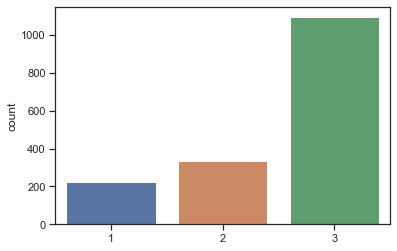

In [13]:
# mari kita plot
plot = sns.countplot(doc_topic)

In [14]:
# Mari kita coba maknai masing-masing topic ini
Top_Words = 25
print('Printing top {0} Topics, with top {1} Words:'.format(n_topics, Top_Words))
tau.print_Topics(lda, tf_terms, n_topics, Top_Words)

Printing top 3 Topics, with top 25 Words:
Topic #1:
edu health com medical child disease report center patient year hiv case cancer number april university aids law trial increase newsletter volume care national public
Topic #2:
not president stephanopoulos be work go time car job question program package ms list year edu support good tax request health keyboard change post group
Topic #3:
not car good time year work problem thing be day government food lot drug long well case help doctor point drive question bad msg buy


In [15]:
# %matplotlib inline
# Mari kita Plot, supaya lebih jelas
# Catatan, bergantung dari laptop yang digunakan, image terkadang cukup lama untuk muncul.
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)  

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.077777  0.086716       1        1  51.464538
1     -0.071614 -0.089134       2        1  30.988058
0      0.149391  0.002418       3        1  17.547404, topic_info=                 Term        Freq       Total Category  logprob  loglift
11481       president  385.000000  385.000000  Default  30.0000  30.0000
14054  stephanopoulos  295.000000  295.000000  Default  29.0000  29.0000
4570              edu  371.000000  371.000000  Default  28.0000  28.0000
6523           health  277.000000  277.000000  Default  27.0000  27.0000
2755              com  241.000000  241.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
16542            year   82.356499  498.899225   Topic3  -5.6258  -0.0611
8266              law   56.857848  185.338567   Topic3  -5.9963   0.5586
2118             care   52.245969  177.203305   Topic3  -6.0808   0.5189
14200           study   48.892701  194.435333   Topic3  -6.1472   0.3598
6266            group   47.042802  224.130324   Topic3  -6.1858   0.1791

[233 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
243        3  0.989939        adl
349        1  0.389595        age
349        2  0.012986        age
349        3  0.597379        age
350        3  0.928458       aged
...      ...       ...        ...
16542      2  0.218481       year
16542      3  0.164362       year
16544      1  0.956894      yeast
16544      2  0.022253      yeast
16555      2  0.974878  yesterday

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

# Bagaimana jika kita ingin menggunakan semi-supervised (guided) LDA?
https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164 

# Bagaimana melakukan Post-Tag sebelum Topic Modelling & Bahasa Indonesia?

In [16]:
# Sumber Data:
# https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_opini_film.csv

url_ = 'https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_opini_film.csv'
file_ = 'data/dataset_tweet_sentiment_opini_film.csv'

try: # Running Locally
    data = pd.read_csv(file_)
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ {url_}
    data = pd.read_csv(file_)
    data.to_csv(file_, encoding='utf-8', index=False)

col = data.columns
print("Kolom di data: ", col)
data = data[col[-1]].values
data[:5]

Kolom di data:  Index(['Id', 'Sentiment', 'Text Tweet'], dtype='object')


array(['Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampah',
       'Film king Arthur ini film paling jelek dari seluruh cerita King Arthur ',
       '@beexkuanlin Sepanjang film gwa berkata kasar terus pada bapaknya',
       'Ane ga suka fast and furious..menurutku kok jelek ya tu film',
       '@baekhyun36 kan gua ga tau film nya, lu bilang perang perangan/? Perang"an disebut ama rp yaoi jadi ambigu :v'],
      dtype=object)

# Preprocessing Bahasa Indonesia

In [17]:
stopID, _ = tau.LoadStopWords(lang='id')
stopID.add('rt'); stopID.add('..')

for i,d in tqdm(enumerate(data)):
    data[i] = tau.cleanText(d, lan='id', lemma=True, stops=stopID, symbols_remove = True, min_charLen = 2)
    
print(data[0])

200it [00:28,  7.02it/s]

jelek film si ernest gak mutu bgt actingnya film sampah


In [18]:
from spacy.lang.id import Indonesian
from nltk.tag import CRFTagger
nlp_id = Indonesian()  # Language Model
ct = CRFTagger()
ct.set_model_file('data/all_indo_man_tag_corpus_model.crf.tagger')

def NLPfilter(t, filters):
    tokens = nlp_id(t)
    tokens = [str(k) for k in tokens if len(k)>2]
    hasil = ct.tag_sents([tokens])
    return [k[0] for k in hasil[0] if k[1] in filters]

In [19]:
filters = set(['NN', 'NNP', 'NNS', 'NNPS', 'JJ'])
NLPfilter(data[0], filters)

['jelek', 'film', 'actingnya', 'film', 'sampah']

In [20]:
data_postTag = []
for i, d in tqdm(enumerate(data)):
    data_postTag.append(NLPfilter(d,filters))

' '.join(data_postTag[0])

200it [00:00, 4999.97it/s]


'jelek film actingnya film sampah'

In [34]:
data = [d for d in data_postTag if d]
print(data[:3])

[['jelek', 'film', 'actingnya', 'film', 'sampah'], ['film', 'king', 'arthur', 'film', 'jelek', 'cerita'], ['film', 'gwa', 'kasar']]


# Evaluasi: Bagaimana mendapatkan parameter Optimal Topic Modelling?

**Beberapa catatan penting**:
1. Hati-hati Struktur Data, untuk melakukan evaluasi Topic Modelling struktur data yang digunakan mirip dengan Word Embedding.
2. Kita akan melakukan cross-validasi dan N-Gram
3. Ada berbagai metric evaluasi https://radimrehurek.com/gensim/models/coherencemodel.html
4. Referensi paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [35]:
bigram_t = Phrases(data, min_count=5)
trigram_t = Phrases(bigram_t[data], min_count=5)
for idx, d in enumerate(data):
    for token in bigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)
    for token in trigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)

# Create a dictionary representation of the documents.
# Remove rare & common tokens
dictionary_t = Dictionary(data)
dictionary_t.filter_extremes(no_below=2, no_above=0.90)
#Create dictionary and corpus required for Topic Modeling
corpus_t = [dictionary_t.doc2bow(doc) for doc in data]
corpus_t = [t for t in corpus_t if t] # remove empty corpus
print('Number of unique tokens: %d' % len(dictionary_t))
print('Number of documents: %d' % len(corpus_t))
print(corpus_t[:1])

Number of unique tokens: 126
Number of documents: 182
[[(0, 2), (1, 1)]]


In [36]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data)
id2word

In [38]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(id2word, corpus, texts, limit=1, start=2, step=1):
    coherence_values = []
    for num_topics in range(start, limit, step):
        LDAmodel_ = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
        cm = CoherenceModel(model=LDAmodel_, texts=texts, corpus=corpus, coherence='c_v')
        with np.errstate(invalid='ignore'):
            coherence_values.append(cm.get_coherence())
    return coherence_values

# Caution cell berikut ini membutuhkan waktu yang cukup signifikan untuk selesai, karena selain LDA *computationally expensive* loopingnya juga melakukan Cross-validasi di setiap jumlah topik *k*

In [41]:
start, step, limit = 2, 1, 10 # Ganti dengan berapa banyak Topic yang ingin di hitung/explore
coh_t, kCV = [], 10 # hati-hati sangat LAMBAT karena cross validasi pada metode yang memang tidak efisien (LDA)

print('iterasi ke: ', end = ' ')
for i in range(kCV):
    print(i+1, end = ', ', flush=True)
    c = compute_coherence_values(id2word, corpus_t, data, limit=limit, start=start, step=step)
    coh_t.append(c)
    
coherence_t = np.mean(np.array(coh_t), axis=0)
'Done'

iterasi ke:  1, 2, 3, 4, 5, 

'Done'

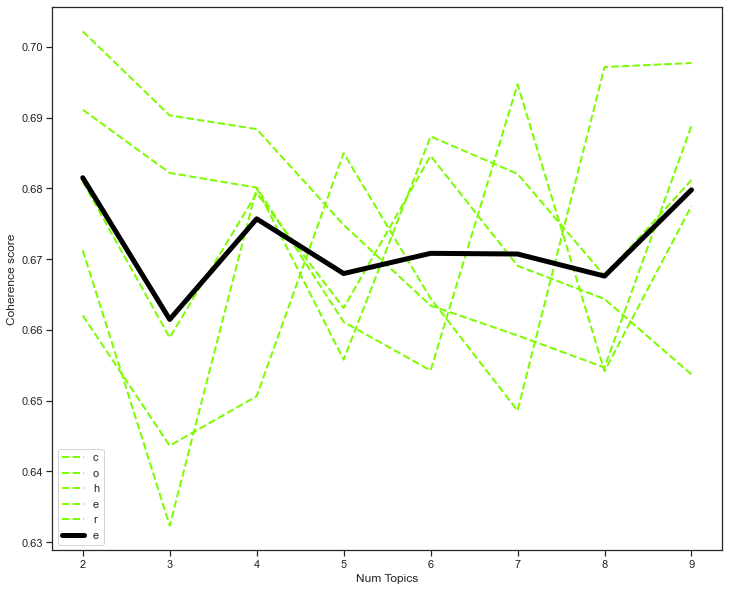

In [42]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(12,10))
for c in coh_t:
    plt.plot(x, c, '--', color = 'lawngreen', linewidth = 2)
plt.plot(x, coherence_t, '-', color = 'black', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Referensi Pilihan:

* perhitungan Manual Topic Modelling LDA: http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/
* http://mimno.infosci.cornell.edu/slides/details.pdf
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* http://www.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf
* http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
* Penjelasan intuitif yang baik: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d 
* inconjunction dengan interactive program berikut: https://lettier.com/projects/lda-topic-modeling/ 

In [43]:
# Langsung Aplikasi-nya
# Perhatikan NMF bisa menggunakan Float
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

data = D.copy()

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(data)
nmf_model = NMF(n_components = 3, random_state=0)
nmf = nmf_model.fit(tfidf)

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tau.print_Topics(nmf, tfidf_feature_names, n_topics, Top_Words)


Topics in NMF model:
Topic #1:
not time msg be food government work year thing drug good problem doctor study case question president job patient health post help disease law day
Topic #2:
geb dsl cadre chastity pitt shameful intellect skepticism surrender bank gordon edu not lyme blood patient migraine weight good medical pressure disease nerve reflex dystrophy
Topic #3:
car drive buy dealer price engine not good model speed mile sell saturn driver year tire ford problem owner time oil small auto light road


In [44]:
# Sama seperti LDA kita bisa melihat distribusi topic setiap dokumen
vsm_topics = nmf.transform(tfidf)
vsm_topics[:10]

array([[0.        , 0.        , 0.15690406],
       [0.06583397, 0.00642889, 0.00487684],
       [0.0050879 , 0.        , 0.0889403 ],
       [0.09121897, 0.0055142 , 0.        ],
       [0.06019741, 0.        , 0.01219569],
       [0.01627222, 0.        , 0.0696    ],
       [0.02104475, 0.        , 0.00707435],
       [0.01055947, 0.        , 0.06018087],
       [0.05167198, 0.        , 0.02317782],
       [0.05389314, 0.        , 0.01252206]])

100%|██████████████████████████████████████████████████████████████████████████████████████| 1653/1653 [00:00<?, ?it/s]

In total there are 3 major topics, distributed as follows


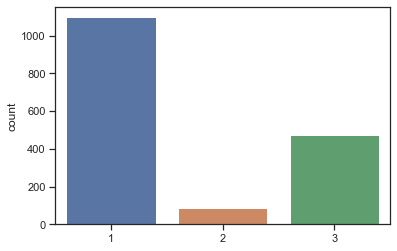

In [45]:
# Seandainya diasumsikan 1 dokumen hanya 1 topic dengan nilai skor topic terbesar
doc_topic =  [a.argmax()+1 for a in tqdm(vsm_topics)] # topic of docs
print('In total there are {0} major topics, distributed as follows'.format(len(set(doc_topic))))
sns.countplot(doc_topic)
plt.show()

# Latihan :

* Load data data tweet dengan isu berbeda.
* Lakukan preprocessing (termasuk lemma) dan pos tag (ambil hanya noun saja)
* Bandingkan hasil topic dari LDA, dan NMF dari data tersebut.
* Apakah hasilnya sudah baik?
* Buat visualisasi pyLDAvis-nya dan analisa lebih lanjut.

# End of Module

<hr />